In [0]:
%matplotlib inline 
import torch
import torch.optim as optim # to use adam optimizer from here
from torchvision import transforms, models #use transforms to perform various transforms on image, models foe vgg19
from PIL import Image #to open our image are perform operations on it
import matplotlib.pyplot as plt
import numpy as np

Downloading our vgg19 model. 

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False) # setting feature params false so we can use the default params of this model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
# use the gpu provided to us by pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Defining a function to load our input image and perform certian operations on it.

In [0]:
def load_image(img_path, max_size=400, shape=None): #max_size is the max size we want our image to be. Shape is defined to make the dimensions of content image and style image equal.
    
    image = Image.open(img_path).convert('RGB') #Open image and convert to RGB
    if max(image.size) > max_size: # Set max size we defined
        size = max_size            
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape    # if the shape is called we just make changes in images to make dimensions equal.
    # perform transforms on our i/p image
    in_transform = transforms.Compose([                
                        transforms.Resize(size), 
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0) #to add extra dimension
    
    return image

Define content and style variables

In [0]:
content = load_image('City.jpg').to(device) # to device where our model is running
style = load_image('StarryNight.jpg').to(device)

Convert image to make it compatible for matplotlib.pyplot

In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze() # to reduce a dimension to match it with the axis of subplots
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(-0.5, 615.5, 399.5, -0.5)

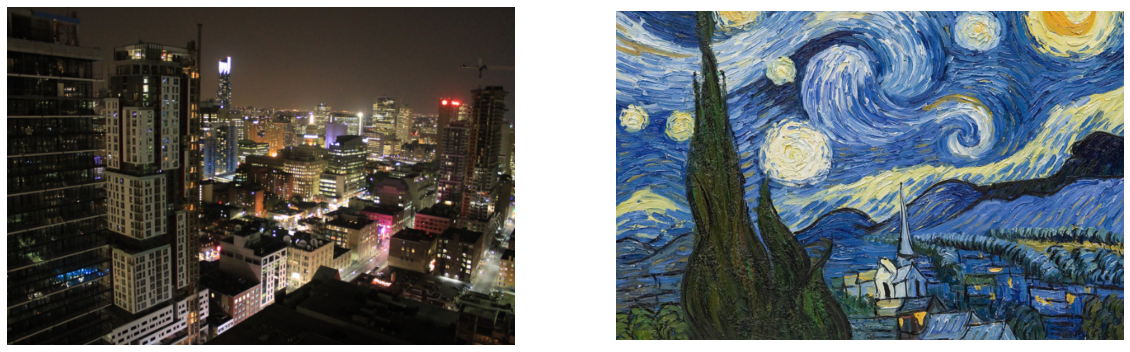

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

For our feature extraction we use specific conv layers output from vgg19 as these layers will give feature outputs which will be best suited for style transfer. As per papers published the 1st layer from each vgg19 batch is taken for style_feature extraction and 2nd layer from 4th batch is taken for content_feature extraction. We use only one layer for content as contents are more clearly extracted by deeper layers. Each layer output collected from style_features can be used to obtain different results.

In [0]:
def get_features(image, model): # get get features from specified layers.
   
    layers = {'0': 'conv1_1', # Style Extraction from 1st layer of each batch.
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {} 

    for name, layer in model._modules.items(): # we first iter through each layer of vgg19.
        image = layer(image)                   #and then pass our input image through each layer.
        if name in layers:                     # we then store outputs from only those layers which we want in our feature dictionary
            features[layers[name]] = image     
            
    return features 

In [0]:
content_features = get_features(content, vgg) # passing our content image through the model. 
style_features = get_features(style, vgg)  # passing our style image through the model

Our content features are perfect but we need to make changes in style features as our CNN while detecting styles also detect other contents in image such as object structure and positioning, hence to remove then we apply Gram matrix.
A Gram matrix is a vector(V) multiplied to its own transpose. V*V(t)

In [0]:
def gram_matrix(tensor): # we pass in our image tensor
    _, d, h, w = tensor.size() # Our image tensor is 4D which we need to unpack, we do not need the first dimension of batch size. So we only take Depth(d),h and w of image.
    tensor = tensor.view(d, h * w) # Converting it to a 2D tensor 
    gram = torch.mm(tensor, tensor.t()) #.mm is matrix multiplication
    return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}  # We apply gram matrix only to our style features

We give weights to every layers in our style features, giving higher weights to the layers we feel are more important for style extraction. The higher layers of vgg19 are more into style extraction so we give them higher weights. 

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha    This ration between aplha:beta is very important. It bring balance to our transfer. 
style_weight = 1e6  # beta     The lower the ratio the more balanced the image is.

We declare our target image as the clone of content image.

In [0]:
target = content.clone().requires_grad_(True).to(device) # This will required gradient descent as we need to update the weights of this image to get output

Now we start with optimization. 

In [0]:
show_every = 1000     # We show output of the itterations after every 300 images.
optimizer = optim.Adam([target], lr=0.003)  #We just readjust params of the target image.
steps = 9000 # Number or itterations we want to do to achieve better accuracy. Higher steps higher accuracy.

height, width, channels = im_convert(target).shape #Taking the dimensions of our traget tensor
image_array = np.empty(shape=(300, height, width, channels)) # This we have done to create a video. We take 300 images from our visualization.
capture_frame = steps/300
counter = 0

Now we itterate our target image 9000 times through vgg19 model. In order to reduce the loss and update the params and to get desired style transfer

Total loss:  640385.5625
Iteration:  1000


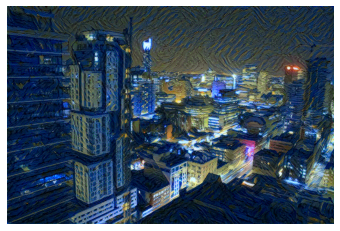

Total loss:  286293.71875
Iteration:  2000


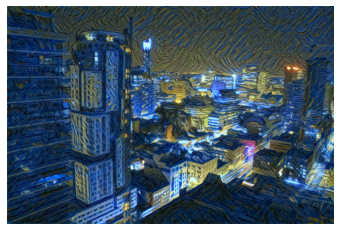

Total loss:  125077.296875
Iteration:  3000


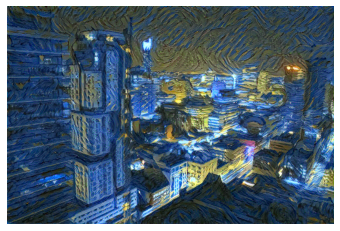

Total loss:  54268.45703125
Iteration:  4000


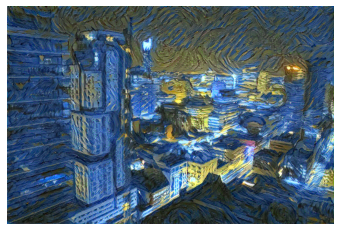

Total loss:  28077.37890625
Iteration:  5000


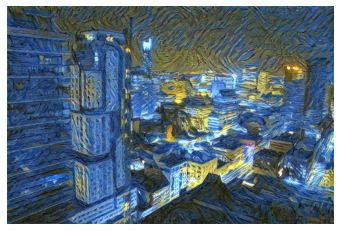

Total loss:  18945.787109375
Iteration:  6000


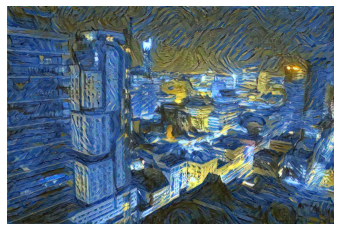

Total loss:  15212.9775390625
Iteration:  7000


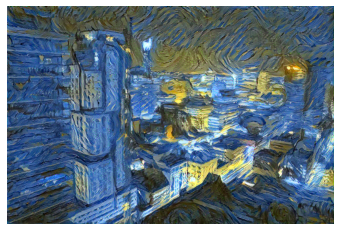

Total loss:  13279.4853515625
Iteration:  8000


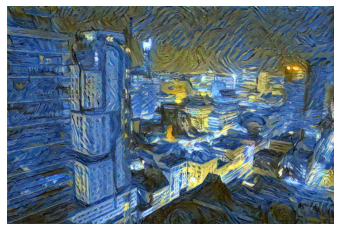

Total loss:  12096.83203125
Iteration:  9000


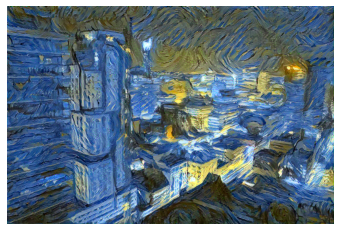

In [15]:
for ii in range(1, steps+1): 
  target_features = get_features(target, vgg) # first we get all the features for target image when it is put in pretrained vgg19 model.
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # Then we subract these feature values to the feature values of contect_image for same layer to get loss.
  style_loss = 0
  
  for layer in style_weights: # We do similar process here but now we just do it for all the 5 layers for style_transfer.
    target_feature = target_features[layer] #We iterate through every single layer out of the 5 selected.
    target_gram = gram_matrix(target_feature) # Converting the target feature to gram matrix.
    style_gram = style_grams[layer] # Style_image, gram matrix of that particular layer. We have alredy done it before.
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2) # Subtract both style_image to target_image features related to style to get total loss. We also multiply the assigned weights per layer.
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w) # to normalize the loss per layer after the gram matrix.
  
  total_loss = content_weight * content_loss + style_weight * style_loss # We calc the total loss here. The content to style weight ratio is already defined before. As our target image is clone of content image the content loss will be low. SO we multiply it with weight 1. But we keep style weight high as that img is totally different
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:   # Show image output progress after every 1000 steps.
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0: # Store the output frames after every 30 steps to get total 300 frames for video processing later.
    image_array[counter] = im_convert(target)
    counter = counter + 1

(-0.5, 599.5, 399.5, -0.5)

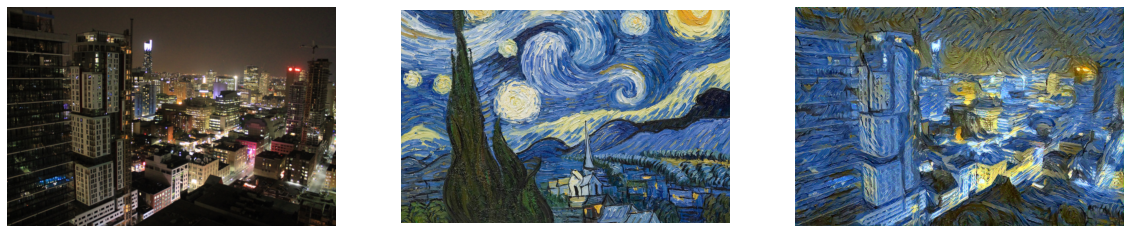

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

Creating a video for proper visualization

In [0]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape # to ensure that the video i/p are of th same dimensions as of our target image.
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height)) # cv2 function to write frames into a video. 30 fps, codec is XVID

for i in range(0, 300): # to use our stored 300 frames output to make a video
  img = image_array[i]
  img = img*255  # we denormalize the images as they are in real world.
  img = np.array(img, dtype = np.uint8) # for cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # as cv2 thinks only in  BGR color space
  vid.write(img)

vid.release()

In [0]:
from google.colab import files
files.download('output.mp4')